In [7]:
import pandas as pd
import numpy as np 
import os

In [8]:
# Move to directory

os.chdir(r'C:\Users\Steven\Desktop')
os.getcwd()

'C:\\Users\\Steven\\Desktop'

In [9]:
# Read the csv file

raw_data = pd.read_csv('synthetic_financial_data.csv')

In [10]:
# Copy the data, so we don't have to read csv file again

data = raw_data.copy()

In [11]:
# Examine the data

data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
# typo - column 'oldbalanceOrg' is supposed to be 'oldbalanceOrig'
data = data.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})

In [13]:
data.shape

(6362620, 11)

In [14]:
# No NaN values is any column

print('Number NaNs:')
data.isna().sum()

Number NaNs:


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [15]:
# Check data for number of unique values in each column

for col in data.columns:
    print(col, len(pd.unique(data[col])))

step 743
type 5
amount 5316900
nameOrig 6353307
oldbalanceOrig 1845844
newbalanceOrig 2682586
nameDest 2722362
oldbalanceDest 3614697
newbalanceDest 3555499
isFraud 2
isFlaggedFraud 2


Text(0.5, 0, 'Type')

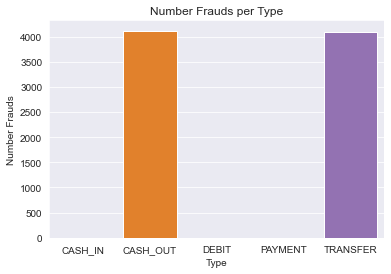

In [16]:
import seaborn as sns

# Plot 1: See how fraud transactions compare across transaction types

plot1_data = data[['type', 'isFraud']].groupby('type').sum()#.plot.bar(rot=0, title='Number of Fraud Transactions per Type', ylabel='Number of Transactions', xlabel='Type', figsize=(15,5))
plot1_data = plot1_data.reset_index()

sns.set_style('darkgrid')
ax = sns.barplot(x="type", y="isFraud", data=plot1_data)
ax.set_title('Number Frauds per Type')
ax.set_ylabel('Number Frauds')
ax.set_xlabel('Type')


In [17]:
# Should note that only transaction types CASH_OUT and TRANSFER contain fraud transactions in our data 

In [18]:
# Label Encode, it is better to one-hot encode, but let's see how well the model performs first

data['type'] = data['type'].replace(data['type'].unique(), [0, 1, 2, 3, 4])
data

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,0,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,0,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,2,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,0,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,2,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,1,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,2,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,1,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [19]:
# Percentage of frauds 

potential_frauds = len(data)
actual_frauds = (data['isFraud'] == 1).sum()
percentage_frauds = actual_frauds/potential_frauds
print('Percentage Frauds:', percentage_frauds)

Percentage Frauds: 0.001290820448180152


In [20]:
# 'nameOrig' and 'nameDest' are not helpful for the model, so will be dropped

data = data.drop(columns=['nameOrig', 'nameDest'])

Text(0.5, 0, 'Correlation')

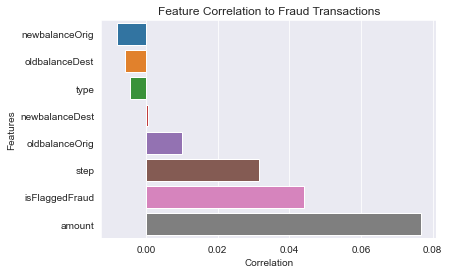

In [21]:
# Feature correlation Plot

corr_data = data.corr()#['isFraud']
corr_data = corr_data.reset_index()
corr_data = corr_data[corr_data['index'] != 'isFraud']
corr_data = corr_data.sort_values('isFraud') 

sns.set_style('darkgrid')
ax = sns.barplot(y='index', x='isFraud', data=corr_data)
ax.set_title('Feature Correlation to Fraud Transactions')
ax.set_ylabel('Features')
ax.set_xlabel('Correlation')


In [22]:
# Scatter plots of highest correlated features

sns.set_style('darkgrid')
#ax = sns.scatterplot(x='isFlaggedFraud', y='amount', hue='isFraud', data=data)

In [23]:
# Prepare data split

X = data.drop(columns='isFraud').to_numpy()
y = data['isFraud'].to_numpy()

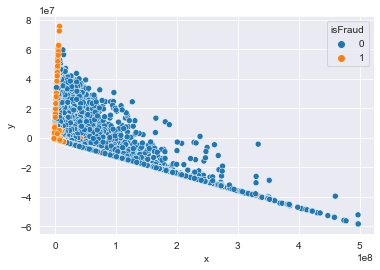

In [24]:
# Dimensionality Reduction w/ PCA to get a better visualization of data
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X, y)
pca_data = pca.transform(X)

pca_df = pd.DataFrame(columns =['x', 'y'], data=pca_data)
pca_df['isFraud'] = y

ax = sns.scatterplot(x='x', y='y', hue='isFraud', data=pca_df)

In [25]:
# K-Fold Cross Validation
from sklearn.model_selection import KFold

kf = KFold(3)

In [26]:
# Sklearn ML Models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import LogisticRegression


gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

gnb = GaussianNB()

dtc = tree.DecisionTreeClassifier()

lr = LogisticRegression()

models = {'lr': lr, 'dtc': dtc, 'gnb': gnb, 'gbc': gbc}


In [27]:
# Just use this instead of the method above...

from sklearn.model_selection import cross_val_score

cv_accs_train = dict()
cv_accs_test = dict()

for model in models.keys():
        print(model)
        results = cross_val_score(models[model], X, y, cv=kf)
        cv_accs_test[model] = results
        print(model, cv_accs_test[model])


lr
lr [0.97833723 0.99963883 0.99813096]
dtc
dtc [0.99953604 0.99979584 0.99919609]
gnb
gnb [0.99869488 0.99241114 0.99257428]
gbc
gbc [0.99902257 0.99592621 0.99775093]


,lr,dtc,gnb,gbc
0,0.978337,0.999536,0.998695,0.999023
1,0.999639,0.999796,0.992411,0.995926
2,0.998131,0.999196,0.992574,0.997751


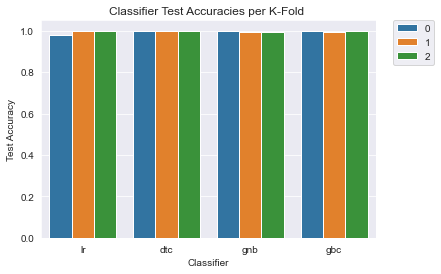

In [46]:
# Classifier Test Accuracies

cv_accs_df = pd.DataFrame(cv_accs_test)
cv_accs_df = cv_accs_df.transpose().reset_index()
cv_accs_df = pd.melt(cv_accs_df, id_vars='index', value_vars=[0,1,2])
cv_accs_df = cv_accs_df.rename(columns={'index': 'Classifier', 'variable': 'K-Fold', 'value': 'Test Accuracy'})

ax = sns.barplot(x='Classifier', y='Test Accuracy', hue='K-Fold', data=cv_accs_df)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Classifier Test Accuracies per K-Fold ')
pd.DataFrame(cv_accs_test)

Text(0.5, 1.0, 'Classifier Test Accuracy Means')

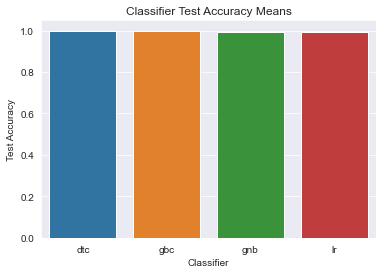

In [53]:
# Average Test Accuracies

cv_accs_mean = cv_accs_df.groupby('Classifier').mean().reset_index()

ax = sns.barplot(x='Classifier', y='Test Accuracy', data=cv_accs_mean)
ax.set_title('Classifier Test Accuracy Means')


In [54]:
# Temporary split for hyper-parameter tuning
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
# I was able to obtain a satisfactory accuracy rate for my model, however there may some issues. The dataset contains an extremely small amount of fraud transactions, thus it makes it difficult for the model to obtain a poor accuracy.
# If I had the time, I would like to apply some methods of handling an imbalanced dataset. Such as different evaluation metrics and resampling.
# I definitely could have also done a better job hyper-parameter tuning and model selection. It takes a long time to run each model, so the time-constraint made it difficult for me to tune the model.
# Specifically the Gradient Boosting Classifier could have been tuned better. Unfortunately, it took too long to run GridSearch to find the best parameters, so I wasnt able to implement it.
# I am comfortable with my visualizations as they are there to present the interesting and notable parts of this project. I would of liked to make more visualizations as well, but it also takes sometime to run.
# The main cleaning that the dataset required was categorical encoding for the 'type' column. I decided to go with Label Encoding here for convenience, but I would definitely like to use One Hot Encoding in the future as it is more appropriate.
# Label Encoding might hurt the model as there is not supposed to be a relationship between transaction types. 
# No imputation was necessary which made it easy. Columns that were identifiers or names were dropped as they are irrelevant.
# The data wasnt shuffled as I felt that the hours passed feature was important to maintain. I kept this feature in mind when I used K-Fold Cross Validation to not split the data set recklessly.
# Some more features could be removed to make it more efficient. The column 'amount' contains details that could be obtained from other columns, such as the oldbalanceOrig and newbalanceOrig.



In [ ]:
# Gridsearch Cross Validation for Hyper-Parameter tuninng
from sklearn.model_selection import GridSearchCV

l_rates = [0.0001,0.001, 0.01, 0.1] #, 0.2, 0.3]
n_ests = [100, 200, 300] #, 400, 500]

params = {'learning_rate': l_rates, 'n_estimators':n_ests}
